In [3]:
# Import libraries and modules
import numpy as np
import pandas as pd
from cqcplot import *
 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib 

In [4]:
%matplotlib inline

In [144]:
# Load data.
wine = pd.read_csv('wine_data.csv', sep=',')

In [145]:
wine.head()

,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,technique,sweetness,type
0,0,6.0,0.31,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,decent,organic,dry,red regular
1,1,7.0,0.53,0.43,6.1,0.029,6.0,76.0,0.99118,3.08,0.50,12.5,very good,organic,dry,white full_bodied
2,2,7.0,0.50,0.25,2.0,0.070,3.0,22.0,0.99630,3.25,0.63,9.2,poor,organic,dry,red fresh
3,3,6.6,0.32,0.26,7.7,0.054,56.0,209.0,0.99610,3.17,0.45,8.8,poor,traditional,dry,white light_bodied
4,4,6.1,0.25,0.30,1.2,0.036,42.0,107.0,0.99100,3.34,0.56,10.8,good,organic,dry,white light_bodied


#### Preprocess column names 

In [146]:
wine.rename(columns={"fixed acidity": "fixed_acidity", "volatile acidity": "volatile_acidity",\
                             'citric acid':'citric_acid', 'residual sugar': 'residual_sugar',\
               'free sulfur dioxide':'free_sulfur_dioxide', 'total sulfur dioxide':'total_sulfur_dioxide',\
                    'type':"wine_type"},inplace=True)

## Explore data

In [147]:
wine.isnull().sum()

Unnamed: 0               0
fixed_acidity            0
volatile_acidity         0
citric_acid              0
residual_sugar           0
chlorides                0
free_sulfur_dioxide      0
total_sulfur_dioxide     0
density                  0
pH                       0
sulphates                0
alcohol                  0
quality                 30
technique                0
sweetness                1
wine_type                0
dtype: int64

In [148]:
wine.shape

(6497, 16)

there are 30 NaNs in the quality column, there is 1 NaN in the swatness variable.
In both cases this Nans are a small fraction of all the 6497 observations 

Get DFs of data with and without NaNs:

In [149]:
nan_cols = ['quality', 'sweetness']
notnans = wine[nan_cols].notnull().all(axis=1)
df_notnans = wine[notnans]

In [150]:
df_nans = wine[~notnans]

In [151]:
df_notnans.shape # sanity check, shapes are correct 

(6466, 16)

In [152]:
df_nans.shape

(31, 16)

In [153]:
31/6497

0.004771432969062644

#### How to fill in the NaN's? 
approch will be to use an ML algorithm (trained on the portion of data without values missing) 
to predict missing values and fill them in 
This is a relatively sohistciated approach, but given that only apporx. 0.5% of data is missing this points could simplpy be removed.

Anywya, first need to have a closer look at the categorical columns and convert srings into factors

#### Initial explore categorical variables 

In [154]:
wine.quality.unique() 

array(['decent', 'very good', 'poor', 'good', 'very poor', nan,
       'exceptional'], dtype=object)

In [155]:
wine.technique.unique()

array(['organic', 'traditional'], dtype=object)

In [156]:
wine.sweetness.unique()

array(['dry', 'off-dry', nan], dtype=object)

In [157]:
wine.wine_type.unique()

array(['red regular', 'white full_bodied', 'red fresh',
       'white light_bodied', 'red intense', 'white bold'], dtype=object)

**Observe:** 
- qulaity has 7 categories including a NaNs category 
- technique and sweatness are binary 
- wine_type has 6 categores
Action: turn categorical strings into numbers


#### COnvert Strings into factors and keep the NaNs

In [158]:
def isOrg(technique):
    if technique=="organic":
        return 1
    elif technique=="traditional" :
        return 0
    else:
        return np.nan

In [159]:
wine['technique'] = wine['technique'].apply(isOrg)

In [160]:
def isType(wine_type):
    if wine_type=='red regular':
        return 5 
    elif wine_type=='red fresh' :
        return 4
    elif wine_type=='red intense' :
        return 3   
    elif wine_type=='white full_bodied' :
        return 2
    elif wine_type=='white light_bodied' :
        return 1  
    elif wine_type== 'white bold':
        return 0   
    else:
        return np.nan

In [161]:
wine['wine_type'] = wine['wine_type'].apply(isType)

In [162]:
def isSweet(sweetness):
    if sweetness== 'dry':
        return 1
    elif sweetness== 'off-dry' :
        return 0
    else:
        return np.nan

In [163]:
wine['sweetness'] = wine['sweetness'].apply(isSweet)

In [164]:
def isTasty(quality):
    if quality == 'exceptional':
        return 5
    elif quality == 'very good':
        return 4
    elif quality == 'good':
        return 3
    elif quality == 'decent':
        return 2
    elif quality == 'poor':
        return 1
    elif quality == 'very poor':
        return 0
    else:
        return np.nan   

In [165]:
wine['quality'] = wine['quality'].apply(isTasty)

In [166]:
assert wine.isnull().sum().sum() == 31 # sanity check we still have same number of NaNs

#### now can fill NaNs

In [167]:
df_nans.head()

,Unnamed: 0,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,technique,sweetness,wine_type
85,85,7.9,0.640,0.46,10.6,0.244,33.0,227.0,0.99830,2.87,0.74,9.10,NaN,traditional,off-dry,white light_bodied
107,107,6.7,0.760,0.02,1.8,0.078,6.0,12.0,0.99600,3.55,0.63,9.95,NaN,organic,dry,red fresh
237,237,6.2,0.230,0.35,0.7,0.051,24.0,111.0,0.99160,3.37,0.43,11.00,NaN,organic,dry,white light_bodied
302,302,6.8,0.815,0.00,1.2,0.267,16.0,29.0,0.99471,3.32,0.51,9.80,NaN,organic,dry,red fresh
540,540,7.6,0.480,0.37,1.2,0.034,5.0,57.0,0.99256,3.05,0.54,10.40,NaN,organic,dry,white light_bodied


In [168]:
from fancyimpute import KNN    

# Use 10 nearest rows which have a feature to fill in each row's missing features
X_filled_knn = KNN(k=10).complete(wine)

Imputing row 1/6497 with 0 missing, elapsed time: 6.248
Imputing row 101/6497 with 0 missing, elapsed time: 6.249
Imputing row 201/6497 with 0 missing, elapsed time: 6.249
Imputing row 301/6497 with 0 missing, elapsed time: 6.249
Imputing row 401/6497 with 0 missing, elapsed time: 6.250
Imputing row 501/6497 with 0 missing, elapsed time: 6.250
Imputing row 601/6497 with 0 missing, elapsed time: 6.250
Imputing row 701/6497 with 0 missing, elapsed time: 6.250
Imputing row 801/6497 with 0 missing, elapsed time: 6.251
Imputing row 901/6497 with 0 missing, elapsed time: 6.251
Imputing row 1001/6497 with 0 missing, elapsed time: 6.251
Imputing row 1101/6497 with 0 missing, elapsed time: 6.251
Imputing row 1201/6497 with 0 missing, elapsed time: 6.252
Imputing row 1301/6497 with 0 missing, elapsed time: 6.252
Imputing row 1401/6497 with 0 missing, elapsed time: 6.252
Imputing row 1501/6497 with 0 missing, elapsed time: 6.252
Imputing row 1601/6497 with 0 missing, elapsed time: 6.253
Imputing 

#### make data back into dataframe and check that NaNs have been filled

In [169]:
clean_wine = pd.DataFrame(X_filled_knn)

In [170]:
clean_wine.rename(columns={0:'Unamed',1: "fixed_acidity", 2: "volatile_acidity",\
                             3:'citric_acid',4: 'residual_sugar',\
               5:'chlorides',6: 'free_sulfur_dioxide', 7:'total_sulfur_dioxide',\
                           8:'density',9:'pH',10: 'sulphates',11: 'alcohol',
      12:'quality',13:'technique',14: 'sweetness',15: 'wine_type'},inplace=True)

In [171]:
assert clean_wine.isnull().sum().sum() == 0

Round filled Quality and Sweetness to 0 decimals:

In [172]:
clean_wine.quality = clean_wine.quality.round(0)
clean_wine.sweetness = clean_wine.sweetness.round(0)

In [173]:
# SAVE PREPROCESSED DATA
clean_wine.to_pickle('./clean_wine_data.pickle')

## Explore fetures and get a feel for what they mean 

In [194]:
wine_explore = clean_wine.copy()

In [195]:
wine_explore['quality'].describe() # Print info on wine

count    6497.000000
mean        1.831461
std         0.852630
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: quality, dtype: float64

In [196]:
wine_explore['quality'].value_counts()

2.0    2857
1.0    2145
3.0    1081
0.0     216
4.0     193
5.0       5
Name: quality, dtype: int64

the "quality" class is unbalenced. Very Poor, poor and decent constitute 5218 out of 6497 samples. The Excellent and very good wines are only 198.  
 

In [216]:
print('Approx.{} of wines in dataset are nothing special '.format(5218/6497))


Approx.0.8031399107280284 of wines in dataset are nothing special 


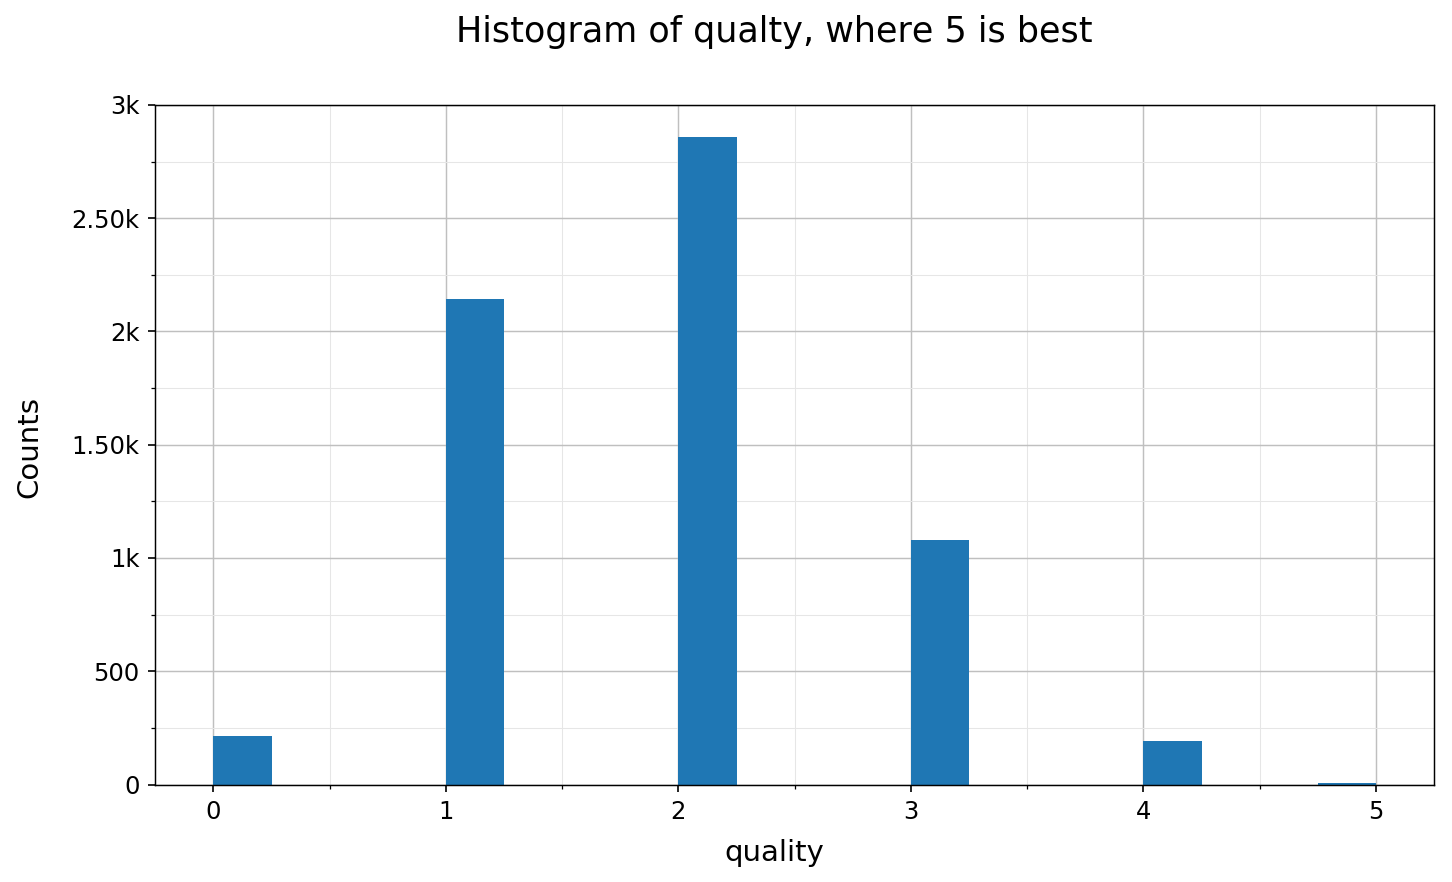

In [214]:
p= hist_plot(wine_explore, 'quality')
p['fig'].suptitle('Histogram of qualty, where 5 is best')   

In [204]:
wine_explore['wine_type'].value_counts()

1.0    3337
2.0    1459
4.0     747
5.0     711
3.0     141
0.0     102
Name: wine_type, dtype: int64

more white wine (index 0/1/2) than red wine

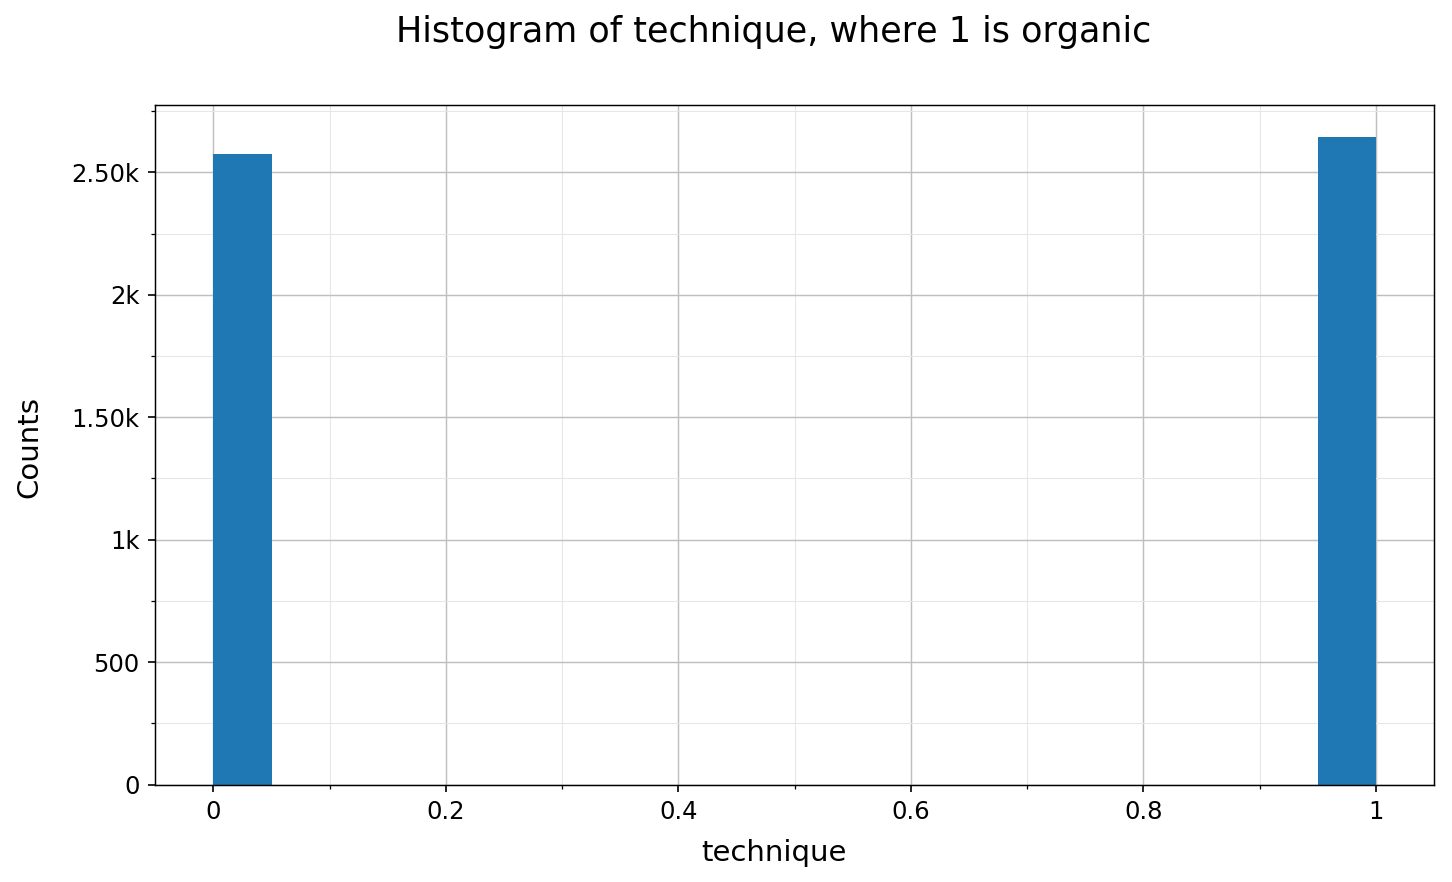

In [220]:
p= hist_plot(wine_explore.query('quality<3'), 'technique')
p['fig'].suptitle('Histogram of technique, where 1 is organic') 

In [199]:
wine_explore.drop('Unamed',axis=1,inplace=True)

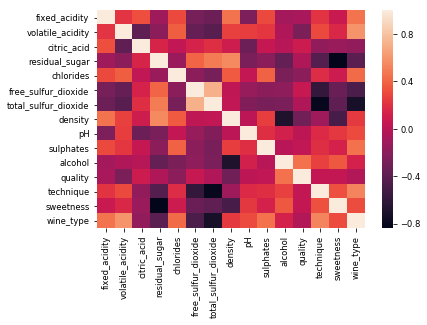

In [200]:
# make correlation matrix 
import seaborn as sns
corr = wine_explore.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

**Observe:** some variables correlate: 1) to be expected that free sulfur dioxide and total sulfur dioxide are correlated, 2) density and residual sugar , 3) volatile acidity and wine type are closely connected, 4)sweetness and residual suggar have strong negative correlation  

In [205]:
def isRed(wine_type):
    if wine_type==5:
        return 1
    elif wine_type==4 :
        return 1
    elif wine_type==3 :
        return 1   
    else: 
        return 0   

In [206]:
wine_explore['isRed']= wine_explore['wine_type'].apply(isRed) 

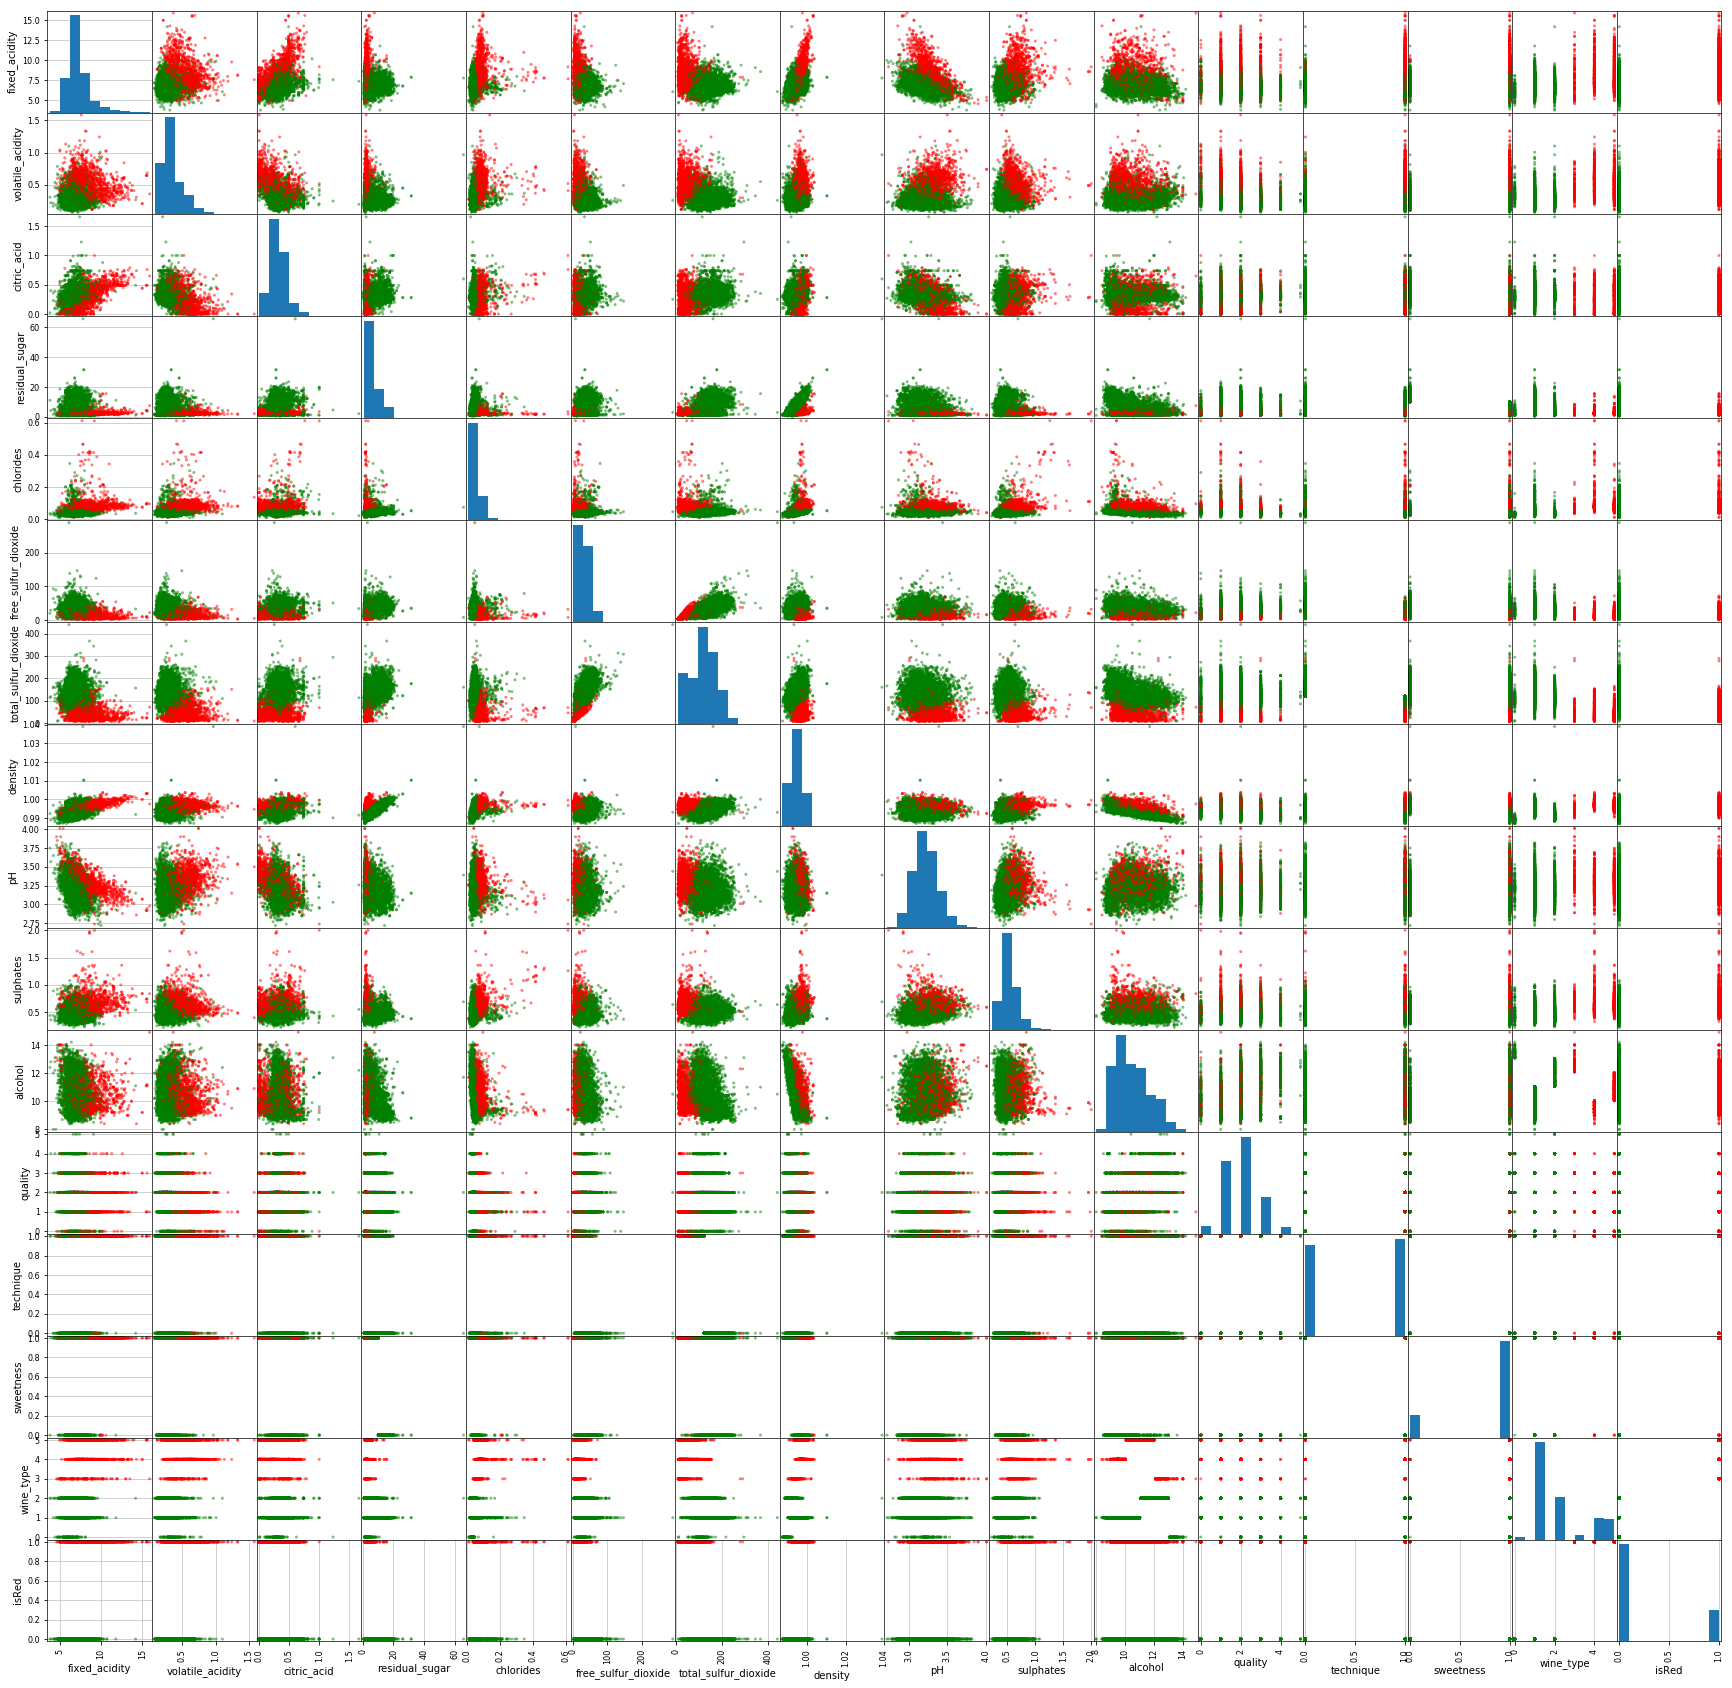

In [208]:
# make a scatter plot
colors=['green','red']
#colors=['green','green','green','red','red','red']
pd.plotting.scatter_matrix(wine_explore,figsize=[30,30],\
                           c=wine_explore.isRed.apply(lambda x:colors[x]))
# save
plt.savefig('scatter_matrix.png')

could consider adding isRed as a feature but due to time constraints I will skip, instead the wine_type is a more robust indicator of the type of wine and if it is red or not 

from the scatter plot above can see that red and white wine (depicted by green) behave differently. There are some linear-like dependencies between fixed acidity and sulphur dioxide content as well as volatile acidity, citric acid and pH
similarly there is some linear relationship between density and alcohol 
the existence of correlations and visible linear -like relationships warrants that a good starting point is to fit a simple linear regression model before trying more complex models 

Model fitting is undertaken in a separate notebook 